# AWS Athena Queries for S3 Data Access Metrics

This notebook runs queries on S3 access logs to deliver metrics on data usage from s3://nasa-maap-data-store, the primary MAAP data store bucket.

Pre-requisites:
* S3 Access Logs have been enabled and are being delivered to a bucket 
* A database already exists in Athena which parses logs delivered to that bucket
* Queries have been developed and saved in Athena

In [2]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
# Must run this with MAAP MCP Ops AWS credentials set in your environment
client = boto3.client('athena')

In [18]:
def start_query(query_id):
    response = client.batch_get_named_query(
        NamedQueryIds=[
            # NASA MAAP Requests for BytesByCollection since October 2022
            query_id,
        ]
    )
    query_string = response['NamedQueries'][0]['QueryString']
    print(f"Starting query {query_string}")
    response = client.start_query_execution(QueryString=query_string)
    query_execution_id = response['QueryExecutionId']
    return query_execution_id

def wait_for_finished(query_execution_id):
    state = 'RUNNING'
    status = None
    while state == 'RUNNING':
        status = client.get_query_execution(
            QueryExecutionId=query_execution_id
        )
        state = status['QueryExecution']['Status']['State']
        if state == 'RUNNING':
            time.sleep(5)
    return status

def get_execution_results(query_execution_id):
    # Could use https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena/paginator/GetQueryResults.html
    # to paginate, however we only want top results.
    results = client.get_query_results(
        QueryExecutionId=query_execution_id,
        MaxResults=500
    )
    return results

top_results_cap = 25
def create_results_dataframe(results_response, no_results=top_results_cap):
    results_list = []
    header_row = results_response['ResultSet']['Rows'][0]['Data']
    columns = [column['VarCharValue'] for column in header_row]
    print(columns)
    # skip the first row which is the header
    for result in results_response['ResultSet']['Rows'][1:]:
        if len(results_list) == no_results:
            break
        collection_result = {}
        for idx, column in enumerate(columns):
            if 'bytessent' in column:
                collection_result['gb_sent'] = int(result['Data'][idx]['VarCharValue'])/1.074e+9
            else:
                collection_result[column] = result['Data'][idx].get('VarCharValue', '')
        # Boreal TIF files were not stored in sub-directory
        if collection_result['collection'] != '' and not 'boreal_agb' in collection_result['collection']:
            results_list.append(collection_result)
    df = pd.DataFrame.from_dict(results_list)
    return df


Reference: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena.html

## Get NASA MAAP total data requested by collection

In [11]:
# We could use list_named_queries if we want to find the query ID by name.
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena/client/list_named_queries.html
nasa_query_uuid = 'dae9ead8-0fa2-4ee0-ad0f-88f2b7a77f7d'
query_execution_id = start_query(nasa_query_uuid)
query_execution_id

Starting query SELECT
  collection, "sum"(bytessent) bytessent_sum
FROM
    (
    SELECT split_part(key, '/', 3) as collection, bytessent
    FROM "nasa_maap_data_store_access_logs_db"."logs"
    WHERE (operation = 'REST.GET.OBJECT' OR operation = 'REST.COPY.PART')
    AND date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000') >= date_parse('01/Oct/2022:00:00:00 +0000', '%d/%b/%Y:%H:%i:%s +0000')
    AND remoteip NOT LIKE '90.84.45%'
    )
GROUP BY collection
ORDER BY bytessent_sum DESC;    


'c520f775-0f61-4f26-ba86-adc257699f37'

In [12]:
wait_for_finished(query_execution_id)

{'QueryExecution': {'QueryExecutionId': 'c520f775-0f61-4f26-ba86-adc257699f37',
  'Query': 'SELECT\n  collection, "sum"(bytessent) bytessent_sum\nFROM\n    (\n    SELECT split_part(key, \'/\', 3) as collection, bytessent\n    FROM "nasa_maap_data_store_access_logs_db"."logs"\n    WHERE (operation = \'REST.GET.OBJECT\' OR operation = \'REST.COPY.PART\')\n    AND date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\') >= date_parse(\'01/Oct/2022:00:00:00 +0000\', \'%d/%b/%Y:%H:%i:%s +0000\')\n    AND remoteip NOT LIKE \'90.84.45%\'\n    )\nGROUP BY collection\nORDER BY bytessent_sum DESC',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3://maap-logging/athena-output/c520f775-0f61-4f26-ba86-adc257699f37.csv'},
  'QueryExecutionContext': {},
  'Status': {'State': 'SUCCEEDED',
   'SubmissionDateTime': datetime.datetime(2023, 4, 8, 10, 25, 20, 315000, tzinfo=tzlocal()),
   'CompletionDateTime': datetime.datetime(2023, 4, 8, 10, 26, 23, 927000, tzinfo=tzlocal())},
  

In [13]:
results = get_execution_results(query_execution_id)
df = create_results_dataframe(results)

<AxesSubplot:xlabel='collection'>

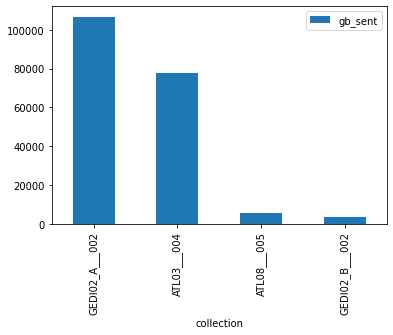

In [14]:
df[0:4].plot.bar(x='collection', y='gb_sent')

<AxesSubplot:xlabel='collection'>

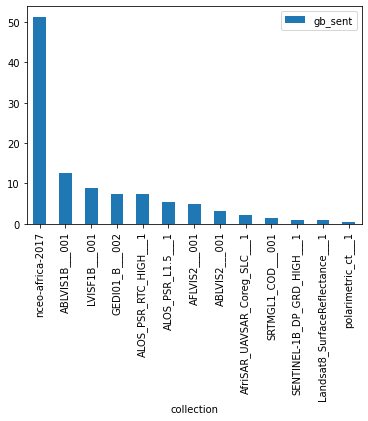

In [15]:
df[4:].plot.bar(x='collection')

## Get ESA MAAP total data requested by collection

In [4]:
esa_query_uuid = '907c98dc-7457-45af-9a8d-e57b49197d97'
query_execution_id = start_query(esa_query_uuid)
query_execution_id

Starting query SELECT
  collection, "sum"(bytessent) bytessent_sum
FROM
    (
    SELECT split_part(key, '/', 3) as collection, bytessent
    FROM "nasa_maap_data_store_access_logs_db"."logs"
    WHERE (operation = 'REST.GET.OBJECT' OR operation = 'REST.COPY.PART')
    AND date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000') >= date_parse('01/Oct/2022:00:00:00 +0000', '%d/%b/%Y:%H:%i:%s +0000')
    AND remoteip LIKE '90.84.45%'
    )
GROUP BY collection
ORDER BY bytessent_sum DESC;    


'9a5a9542-8747-4aa5-a3f5-553fb788e657'

In [5]:
wait_for_finished(query_execution_id)

{'QueryExecution': {'QueryExecutionId': '9a5a9542-8747-4aa5-a3f5-553fb788e657',
  'Query': 'SELECT\n  collection, "sum"(bytessent) bytessent_sum\nFROM\n    (\n    SELECT split_part(key, \'/\', 3) as collection, bytessent\n    FROM "nasa_maap_data_store_access_logs_db"."logs"\n    WHERE (operation = \'REST.GET.OBJECT\' OR operation = \'REST.COPY.PART\')\n    AND date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\') >= date_parse(\'01/Oct/2022:00:00:00 +0000\', \'%d/%b/%Y:%H:%i:%s +0000\')\n    AND remoteip LIKE \'90.84.45%\'\n    )\nGROUP BY collection\nORDER BY bytessent_sum DESC',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3://maap-logging/athena-output/9a5a9542-8747-4aa5-a3f5-553fb788e657.csv'},
  'QueryExecutionContext': {},
  'Status': {'State': 'SUCCEEDED',
   'SubmissionDateTime': datetime.datetime(2023, 4, 8, 10, 22, 10, 869000, tzinfo=tzlocal()),
   'CompletionDateTime': datetime.datetime(2023, 4, 8, 10, 23, 20, 624000, tzinfo=tzlocal())},
  'Sta

In [9]:
results = get_execution_results(query_execution_id)
df = create_results_dataframe(results)

<AxesSubplot:xlabel='collection'>

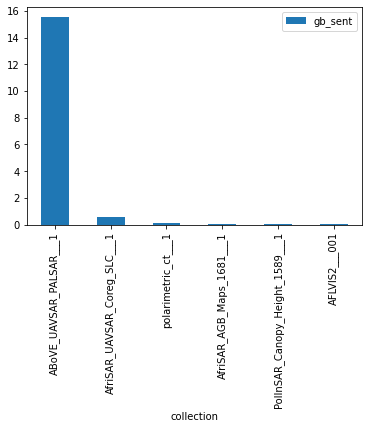

In [10]:
df.plot.bar(x='collection', y='gb_sent')

## Get collection volume requested by month

In [5]:
monthlies_query_uuid = '443d7bad-e3ff-476f-99f3-9d50db08a3d4'
query_execution_id = start_query(monthlies_query_uuid)
query_execution_id

Starting query WITH bytes_and_dates_collection_requests AS (
    SELECT 
        split_part(key, '/', 3) as collection, 
        bytessent, 
        operation,
        month(date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000')) as month,
        date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000') as parsed_requestdatetime,
        date_parse('01/Oct/2022:00:00:00 +0000', '%d/%b/%Y:%H:%i:%s +0000') as october_first_datetime
    FROM 
        "nasa_maap_data_store_access_logs_db"."logs"
)
SELECT
    collection, 
    SUM(bytessent) as bytessent_sum,
    month
FROM
    bytes_and_dates_collection_requests
WHERE 
    (operation = 'REST.GET.OBJECT' OR operation = 'REST.COPY.PART')
    AND parsed_requestdatetime >= october_first_datetime
GROUP BY 
    collection, month
ORDER BY 
    bytessent_sum DESC;


'026c1b11-af05-4b29-af24-712ddab61374'

In [6]:
wait_for_finished(query_execution_id)

{'QueryExecution': {'QueryExecutionId': '026c1b11-af05-4b29-af24-712ddab61374',
  'Query': 'WITH bytes_and_dates_collection_requests AS (\n    SELECT \n        split_part(key, \'/\', 3) as collection, \n        bytessent, \n        operation,\n        month(date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\')) as month,\n        date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\') as parsed_requestdatetime,\n        date_parse(\'01/Oct/2022:00:00:00 +0000\', \'%d/%b/%Y:%H:%i:%s +0000\') as october_first_datetime\n    FROM \n        "nasa_maap_data_store_access_logs_db"."logs"\n)\nSELECT\n    collection, \n    SUM(bytessent) as bytessent_sum,\n    month\nFROM\n    bytes_and_dates_collection_requests\nWHERE \n    (operation = \'REST.GET.OBJECT\' OR operation = \'REST.COPY.PART\')\n    AND parsed_requestdatetime >= october_first_datetime\nGROUP BY \n    collection, month\nORDER BY \n    bytessent_sum DESC',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3:

In [25]:
results = get_execution_results(query_execution_id)
df = create_results_dataframe(results, no_results=10000)

['collection', 'bytessent_sum', 'month']


In [26]:
df.head()

,collection,gb_sent,month
0,ATL03___004,77758.916119,10
1,GEDI02_A___002,30729.569997,3
2,GEDI02_A___002,29977.977281,2
3,GEDI02_A___002,29027.594545,1
4,GEDI02_A___002,7813.718059,10


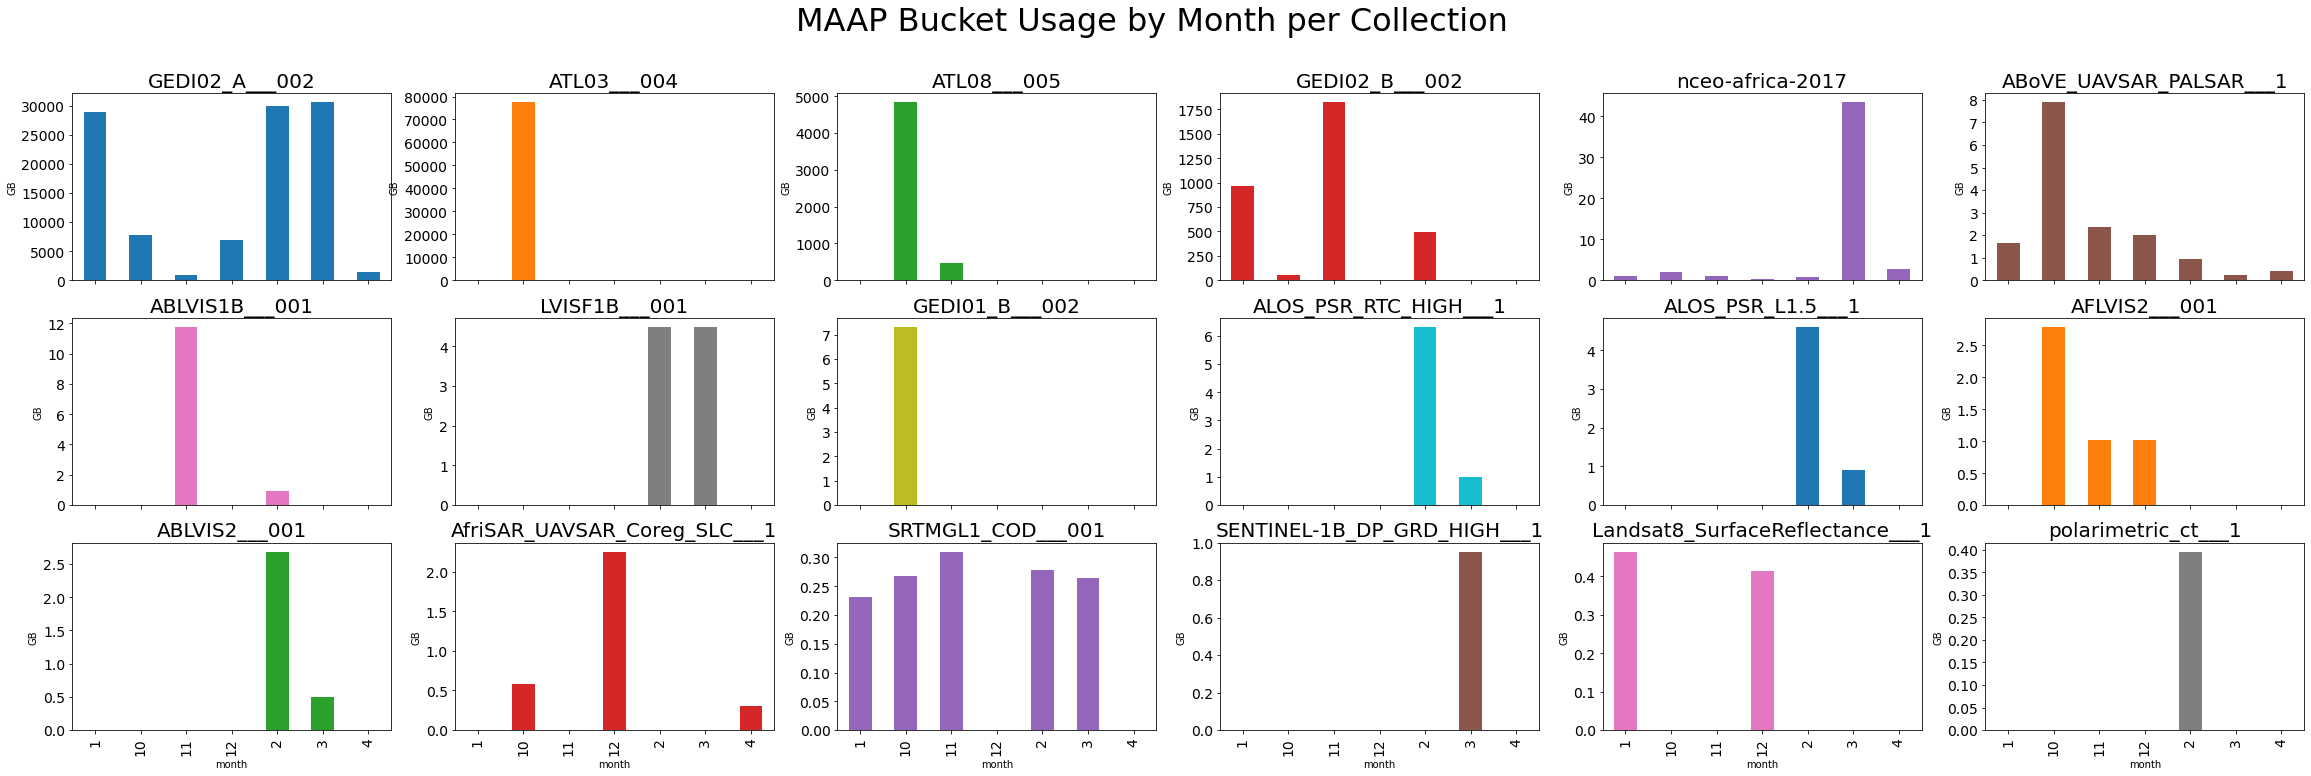

In [27]:
collection_usage_order = df.groupby(['collection'])['gb_sent'].sum().sort_values(ascending=False)
sorter = list(collection_usage_order.to_dict().keys())

collection_pivot = pd.pivot_table(df,
              index='month', 
              columns='collection',
              values='gb_sent')

# sort the collections by most used first and plot
axes = collection_pivot.reindex(sorter, axis=1).plot.bar(
    subplots=True,
    layout=(5,6), 
    figsize=(40, 20),
    legend=False,
    ylabel="GB",
    fontsize=14)

# https://stackoverflow.com/a/66288048/237354
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        #print(f'{i},{j},{(i*6)+j}')
        if ((i*6)+j) < len(sorter):
            ax.set_title(f'{sorter[(i*6)+j]}', fontsize=20)
        
# magic formattting https://stackoverflow.com/a/66288048/237354
fig = axes[0,0].get_figure()
_ = fig.suptitle(f'MAAP Bucket Usage by Month per Collection', fontsize=32, y=0.94)